In [32]:
# imports

import pandas as pd

from statsmodels.api import OLS, add_constant
import pandas_datareader.data as web

from linearmodels.asset_pricing import LinearFactorModel

import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

In [69]:
start = "2021-01-01"
end = "2023-11-01"

ff_factor = 'F-F_Research_Data_5_Factors_2x3'
ff_factor_data = web.DataReader(ff_factor, 'famafrench', start=start, end=end)[0]
ff_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 33 entries, 2021-01 to 2023-09
Freq: M
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  33 non-null     float64
 1   SMB     33 non-null     float64
 2   HML     33 non-null     float64
 3   RMW     33 non-null     float64
 4   CMA     33 non-null     float64
 5   RF      33 non-null     float64
dtypes: float64(6)
memory usage: 1.8 KB


In [34]:
ff_factor_data.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2021-01,-0.03,6.94,3.01,-3.78,4.94,0.01
2021-02,2.78,4.54,7.15,0.39,-1.94,0.00
2021-03,3.08,-0.88,7.39,6.36,3.42,0.00
2021-04,4.93,-3.16,-0.95,2.44,-2.70,0.00
2021-05,0.29,1.22,7.09,2.45,3.04,0.00


In [62]:
# BDC tickers

bdc_tickers = [
    'ARCC',
    "BBDC",
    "BCSF",
    "BKCC",
    "BXSL",
    "CCAP",
    "CGBD",
    "CION",
    "CSWC",
    "FCRD",
    "FDUS",
    "FSK",
    "GAIN",
    "GBDC",
    "GECC",
    "GLAD",
    "GSBD",
    "HRZN",
    "HTGC",
    "ICMB",
    "LRFC",
    "MAIN",
    "MFIC",
    "MRCC",
    "NMFC",
    "OBDC",
    "OCSL",
    "OFS",
    "OXSQ",
    "PFLT"
    ]

print(bdc_tickers)

['ARCC', 'BBDC', 'BCSF', 'BKCC', 'BXSL', 'CCAP', 'CGBD', 'CION', 'CSWC', 'FCRD', 'FDUS', 'FSK', 'GAIN', 'GBDC', 'GECC', 'GLAD', 'GSBD', 'HRZN', 'HTGC', 'ICMB', 'LRFC', 'MAIN', 'MFIC', 'MRCC', 'NMFC', 'OBDC', 'OCSL', 'OFS', 'OXSQ', 'PFLT']


In [36]:
# Create a dictionary to store the historical data for each stock
stock_data_dict = {}

# Fetch historical data for each stock
for ticker in bdc_tickers:
    try:
        stock_data = yf.download(ticker, start=start, end=end, interval="1wk")  # Weekly data
        stock_data_dict[ticker] = stock_data
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

sample_ticker = bdc_tickers[0]
print(stock_data_dict[sample_ticker].head())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [63]:
# Create a dictionary to store the historical data for each stock
stock_data_dict = {}

# Fetch historical data for each stock
for ticker in bdc_tickers:
    try:
        tic = yf.Ticker(ticker)
        stock_data = tic.history(start=start, end=end, interval="1wk")  # Weekly data
        dividends = stock_data['Dividends']
        stock_data['Adj Close with Div'] = stock_data['Close'].copy()
        for date, div in dividends.items():
            if div > 0:
                stock_data.loc[date:, 'Adj Close with Div'] *= (1 + div / stock_data.loc[date, 'Close'])
        stock_data_dict[ticker] = stock_data
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

sample_ticker = bdc_tickers[0]
print(stock_data_dict[sample_ticker].head())

                                Open       High        Low      Close  \
Date                                                                    
2021-01-01 00:00:00-05:00  13.095905  13.273712  12.686174  13.103636   
2021-01-08 00:00:00-05:00  13.265981  13.265981  12.949020  13.196404   
2021-01-15 00:00:00-05:00  13.188671  13.613863  13.150018  13.606133   
2021-01-22 00:00:00-05:00  13.567479  13.621596  13.397403  13.521095   
2021-01-29 00:00:00-05:00  13.451520  13.915366  13.258251  13.783943   

                             Volume  Dividends  Stock Splits  \
Date                                                           
2021-01-01 00:00:00-05:00   7163500        0.0           0.0   
2021-01-08 00:00:00-05:00   8631600        0.0           0.0   
2021-01-15 00:00:00-05:00   5876800        0.0           0.0   
2021-01-22 00:00:00-05:00   9901300        0.0           0.0   
2021-01-29 00:00:00-05:00  10028500        0.0           0.0   

                           Adj Close wi

In [64]:
# We can condense all these dataframes into a single one with the same date range and the assets as columns

# Create a new dataframe to store the adjusted close price of the stocks
adj_close_df = pd.DataFrame(index=stock_data_dict[sample_ticker].index)

# Add the adjusted close price of each stock to the dataframe
for ticker in stock_data_dict.keys():
    adj_close_df[ticker] = stock_data_dict[ticker]['Adj Close with Div']

# Remove columns with more than 5% missing values
adj_close_df = adj_close_df.dropna(axis=1, thresh=int(len(adj_close_df) * 0.95))

adj_close_df.head()

,ARCC,BBDC,BCSF,BKCC,CCAP,CGBD,CSWC,FCRD,FDUS,FSK,...,LRFC,MAIN,MFIC,MRCC,NMFC,OBDC,OCSL,OFS,OXSQ,PFLT
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00-05:00,13.103636,6.926607,9.362023,2.039935,11.058431,7.827459,13.599757,3.042621,10.002694,11.891967,...,13.742493,25.665222,8.127939,6.321391,9.201120,9.624815,12.875072,5.238889,2.276743,8.364073
2021-01-08 00:00:00-05:00,13.196404,7.042050,9.611980,2.047435,11.021197,8.094879,13.666242,3.002268,10.084018,12.142471,...,14.105899,26.302842,8.784594,6.388402,9.232444,9.905004,13.123538,5.216341,2.491123,8.687214
2021-01-15 00:00:00-05:00,13.606133,7.080533,9.771044,2.182430,11.624381,8.080423,13.621920,2.945774,10.150555,12.100719,...,15.674281,26.653878,8.974295,6.470304,9.287259,10.124608,13.033186,5.216341,2.508110,8.466587
2021-01-22 00:00:00-05:00,13.521095,6.918912,9.566533,2.384924,11.400981,7.928646,13.540661,2.663302,9.677403,11.898926,...,15.789042,26.770730,8.908630,6.485196,9.067999,9.882285,12.649194,5.186276,2.458654,8.483102
2021-01-29 00:00:00-05:00,13.783943,7.065140,9.725596,2.527419,11.505234,8.275569,14.523152,3.050692,9.965729,12.601729,...,14.497994,27.415763,9.492324,6.485196,9.279428,10.147326,13.191301,5.532028,2.755388,8.827942


In [65]:
# Compute the monthly returns dataframe

returns = adj_close_df.pct_change().dropna()

monthly_returs = returns.resample('M').last()
monthly_returs.head()

,ARCC,BBDC,BCSF,BKCC,CCAP,CGBD,CSWC,FCRD,FDUS,FSK,...,LRFC,MAIN,MFIC,MRCC,NMFC,OBDC,OCSL,OFS,OXSQ,PFLT
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-31 00:00:00-05:00,0.019440,0.021135,0.016627,0.059748,0.009144,0.043756,0.072559,0.145455,0.029794,0.059064,...,-0.081769,0.024095,0.065520,0.000000,0.023316,0.026820,0.042857,0.066667,0.120690,0.040650
2021-02-28 00:00:00-05:00,0.018142,0.054865,0.051466,0.021944,0.052340,0.037613,0.012104,0.002532,0.066621,0.028198,...,-0.004224,0.046708,0.020408,0.014894,0.027755,0.008715,0.003273,0.088624,0.010363,0.011844
2021-03-31 00:00:00-04:00,0.024905,0.023162,0.017088,0.048193,0.007474,0.022217,0.024691,0.005000,0.023468,0.045549,...,-0.001300,0.035645,0.018355,0.040527,0.021600,0.042646,0.011327,0.069143,-0.035714,-0.002496
2021-04-30 00:00:00-04:00,-0.028047,0.005747,-0.009346,-0.012887,-0.053319,-0.035791,-0.023714,0.004608,0.044991,0.007663,...,0.021673,-0.022296,-0.002034,-0.013927,-0.013647,-0.028276,-0.007374,0.045300,-0.010000,0.000787
2021-05-31 00:00:00-04:00,0.015400,0.021033,0.005668,0.036675,0.004348,0.027591,-0.012528,0.015086,0.032089,0.040018,...,0.051431,0.012801,0.036247,0.056985,0.003019,0.013908,0.005962,0.043571,0.014315,0.011905


In [66]:
# Align the data

ff_factor_data = ff_factor_data.loc[monthly_returs.index[0]:monthly_returs.index[-1]]
ff_factor_data.head()

/var/folders/rs/k8yvpht95zxbr8d7v79msjk00000gn/T/ipykernel_58478/2079011801.py:3: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  ff_factor_data = ff_factor_data.loc[monthly_returs.index[0]:monthly_returs.index[-1]]


,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2021-02-28,2.78,4.54,7.15,0.39,-1.94
2021-03-31,3.08,-0.88,7.39,6.36,3.42
2021-04-30,4.93,-3.16,-0.95,2.44,-2.70
2021-05-31,0.29,1.22,7.09,2.45,3.04
2021-06-30,2.75,-0.34,-7.87,-2.14,-0.94


In [70]:
# Check that dates are aligned properly
print(min(ff_factor_data.index))
print(max(ff_factor_data.index))
print(min(monthly_returs.index))
print(max(monthly_returs.index))

2021-01
2023-09
2021-01-31 00:00:00-05:00
2023-10-31 00:00:00-04:00


In [71]:
# drop the last entry in the monthly_returs dataframe
monthly_returs = monthly_returs.iloc[:-1]

In [72]:
print(len(ff_factor_data))
print(len(monthly_returs))

33
33


In [73]:
mod = LinearFactorModel(portfolios=monthly_returs, 
                        factors=ff_factor_data)
res = mod.fit()
print(res)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 28   R-squared:                      0.1747
No. Factors:                          6   J-statistic:                    361.85
No. Observations:                    33   P-value                         0.0000
Date:                  Sat, Nov 25 2023   Distribution:                 chi2(22)
Time:                          11:51:12                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF        -2.6097     2.8148    -0.9272     0.3538     -8.1265      2.9071
SMB            3.1886     1.4203    

# Running ff macbeth regression raw...

In [45]:
ff_factor_data = ff_factor_data.drop('RF', axis=1) # Remove the risk-free rate

# Set ff_factor_data index to the same as monthly_returns
ff_factor_data.index = monthly_returs.index

ff_factor_data.head()

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2021-01-31,-0.03,6.94,3.01,-3.78,4.94
2021-02-28,2.78,4.54,7.15,0.39,-1.94
2021-03-31,3.08,-0.88,7.39,6.36,3.42
2021-04-30,4.93,-3.16,-0.95,2.44,-2.70
2021-05-31,0.29,1.22,7.09,2.45,3.04


In [46]:
# Step 1: N time series regression (N = # portfolios/assets) of excess returns on factors to estimate factor loadings
betas = []
for ticker in monthly_returs.columns:
    step1 = OLS(endog=monthly_returs[ticker],
                exog=add_constant(ff_factor_data)).fit()
    betas.append(step1.params)

In [47]:
betas = pd.DataFrame(betas, columns=ff_factor_data.columns, index=monthly_returs.columns)
betas.head()

,Mkt-RF,SMB,HML,RMW,CMA
ARCC,-0.000934,0.001660,0.000469,-0.000281,-0.001130
BBDC,0.000374,0.000510,0.002158,0.000792,-0.002672
BCSF,-0.000165,0.002029,0.000894,0.001247,-0.001637
BKCC,0.000073,0.002480,0.000467,-0.000067,0.000225
CCAP,0.000099,0.005387,-0.001001,0.003050,0.001407


In [48]:
# Step 2: T cross-sectional regression (T = # time periods) to estimate risk premia
# Risk factor premia is the time average, we can get a t-stat to assess each factor's significance under the assumption
# that each premia is independent over time...

lambdas = []
for period in monthly_returs.index:
    step2 = OLS(endog=monthly_returs.loc[period, betas.index],
                exog=betas).fit()
    lambdas.append(step2.params)

In [49]:
lambdas = pd.DataFrame(lambdas, columns=betas.columns.tolist(), index=monthly_returs.index)
lambdas.head()

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2021-01-31,-9.297244,18.117720,9.931907,-12.503039,8.097745
2021-02-28,1.300295,9.152834,0.535345,-2.323995,-12.991066
2021-03-31,1.032870,4.674074,10.525117,-4.725266,-1.299955
2021-04-30,5.770935,-2.804680,-9.127389,-9.255375,-7.261590
2021-05-31,-1.164154,4.390366,13.171470,2.032828,2.775375


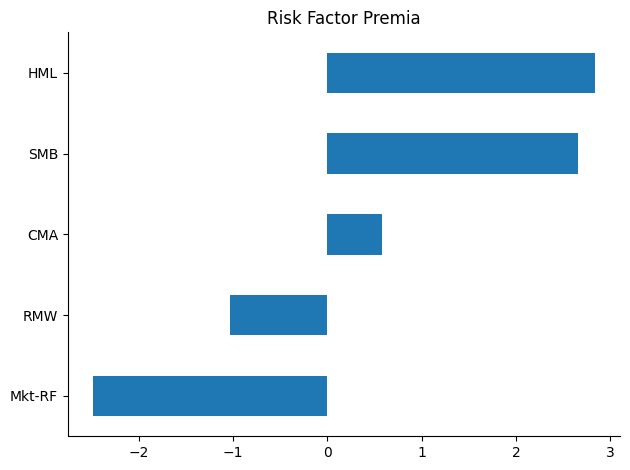

In [50]:
lambdas.mean().sort_values().plot.barh(title='Risk Factor Premia')
sns.despine()
plt.tight_layout()

In [51]:
t = lambdas.mean() / lambdas.std()
print("t-statistics for each factor: (these are the factor risk premia estimates divided by their standard errors)")
t

t-statistics for each factor: (these are the factor risk premia estimates divided by their standard errors)


Mkt-RF   -0.236067
SMB       0.497944
HML       0.188685
RMW      -0.181901
CMA       0.067675
dtype: float64

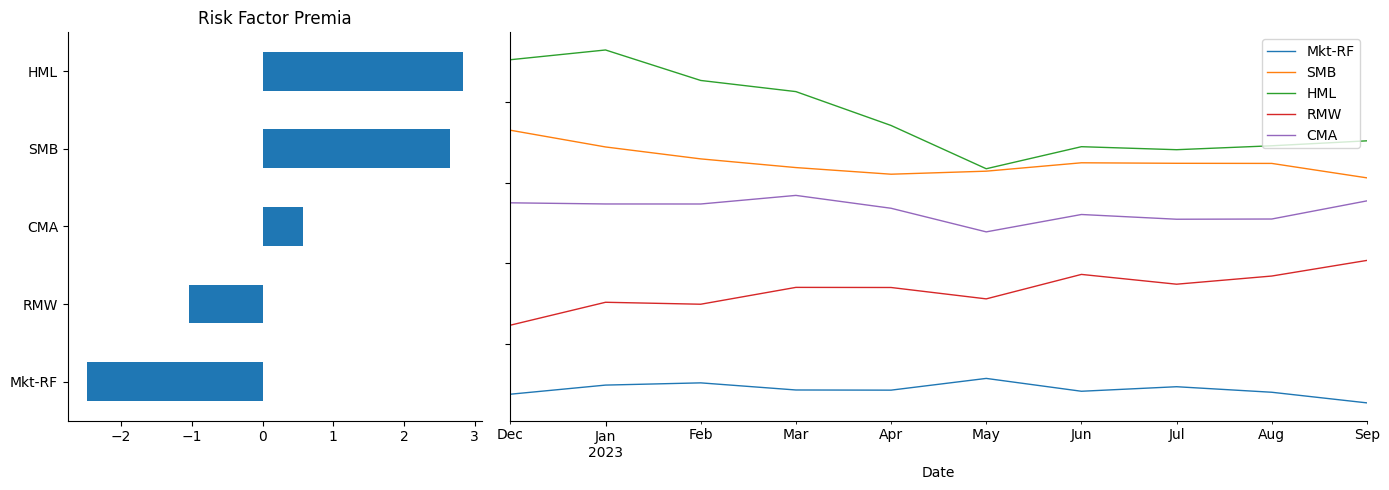

In [52]:
window = 24
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=2)
lambdas.mean().sort_values().plot.barh(title='Risk Factor Premia', ax=ax1)
lambdas.rolling(window).mean().dropna().plot(lw=1, sharey=True, ax=ax2, figsize=(14, 5))
sns.despine()
plt.tight_layout()

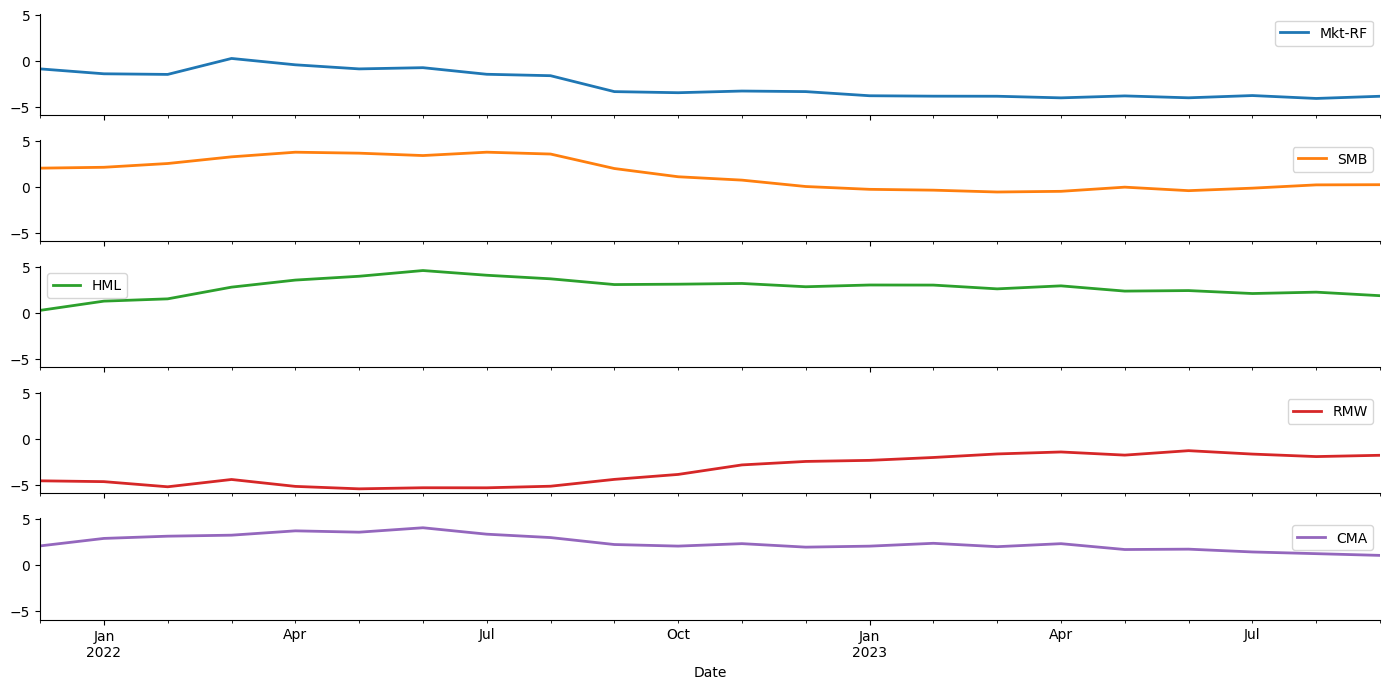

In [31]:
window = 24  # months
lambdas.rolling(window).mean().dropna().plot(lw=2,
                                             figsize=(14, 7),
                                             subplots=True,
                                             sharey=True)
sns.despine()
plt.tight_layout()

# Inclusive of dividends

In [55]:
# Fetch historical data for OCSL
ticker = "OCSL"
ocsl = yf.Ticker(ticker)

# Get historical stock prices and dividends
data = ocsl.history(start=start, end=end, interval="1wk")
dividends = data['Dividends']

dividends.head()

Date
2021-01-01 00:00:00-05:00    0.0
2021-01-08 00:00:00-05:00    0.0
2021-01-15 00:00:00-05:00    0.0
2021-01-22 00:00:00-05:00    0.0
2021-01-29 00:00:00-05:00    0.0
Name: Dividends, dtype: float64

In [56]:
# Calculate adjusted close that includes reinvested dividends
data['Adj Close with Div'] = data['Close'].copy()
for date, div in dividends.items():
    if div > 0:
        data.loc[date:, 'Adj Close with Div'] *= (1 + div / data.loc[date, 'Close'])

# Calculate monthly returns including dividends
monthly_returns = data['Adj Close with Div'].resample('M').ffill().pct_change()

# Drop NaN values and preview the data
monthly_returns = monthly_returns.dropna()
print(monthly_returns.head())  # Display the first few rows of the monthly returns including dividends

Date
2021-02-28 00:00:00-05:00    0.049657
2021-03-31 00:00:00-04:00    0.066265
2021-04-30 00:00:00-04:00    0.076800
2021-05-31 00:00:00-04:00    0.002971
2021-06-30 00:00:00-04:00    0.040203
Freq: M, Name: Adj Close with Div, dtype: float64


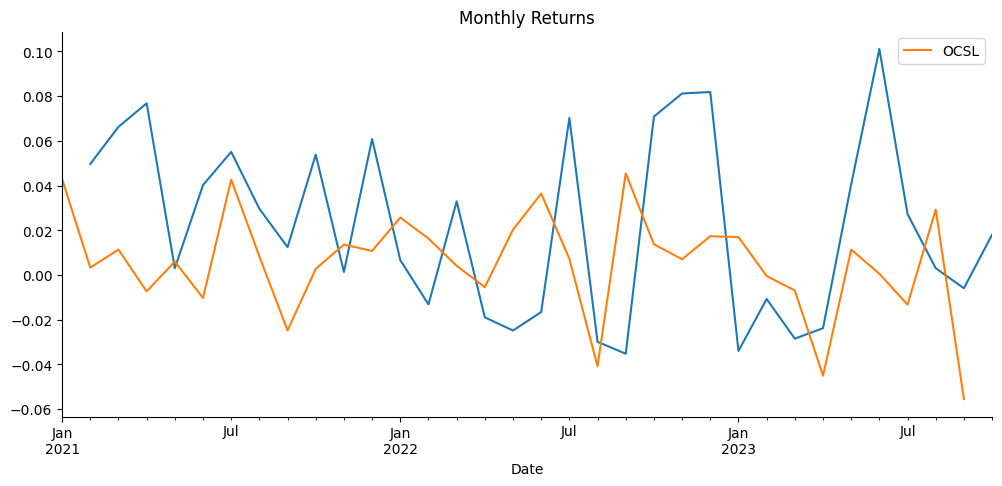

In [58]:
# Plot the original monthly returns for OCSL and the newly made monthly_returns

monthly_returns.plot(title='Monthly Returns', figsize=(12, 5))
monthly_returs['OCSL'].plot(legend=True)
sns.despine()

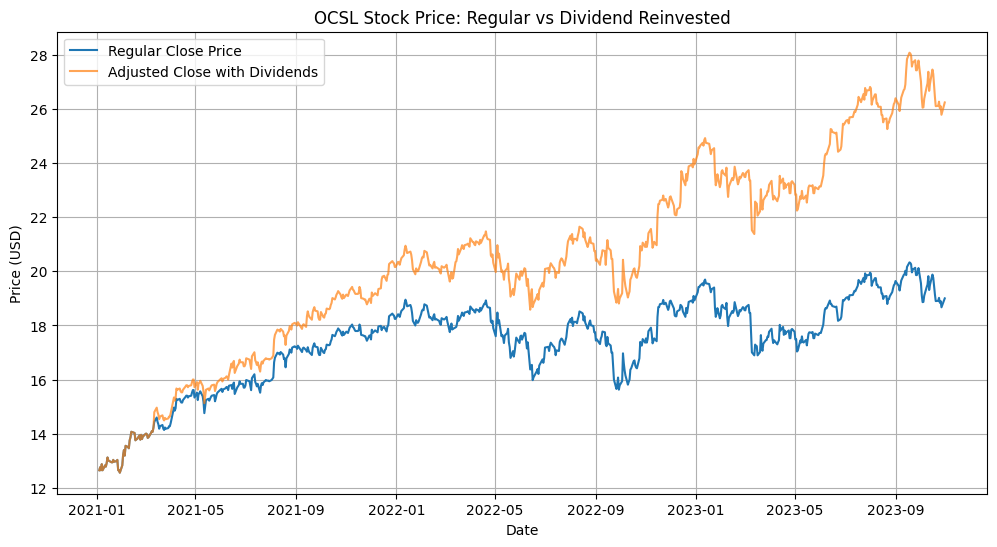

In [75]:
import yfinance as yf
import matplotlib.pyplot as plt

# Fetch historical data for OCSL
ticker = "OCSL"
ocsl = yf.Ticker(ticker)
data = ocsl.history(start=start, end=end)

# Calculate adjusted close with reinvested dividends
data['Adj Close with Div'] = data['Close'].copy()
for date, div in data['Dividends'].items():
    if div > 0:
        data.loc[date:, 'Adj Close with Div'] *= (1 + div / data.loc[date, 'Close'])

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Regular Close Price')
plt.plot(data.index, data['Adj Close with Div'], label='Adjusted Close with Dividends', alpha=0.7)
plt.title('OCSL Stock Price: Regular vs Dividend Reinvested')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()
